# Node Feature Importance

In [ ]:
import sys
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

path = os.path.join('..', '.')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))
    
import warnings
warnings.filterwarnings('ignore')

label_size = 12
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['figure.dpi'] = 300


In [93]:
with open('datasets/x18_exp_l2_graph_dict.pkl', 'rb') as f:
    dataset = pkl.load(f)
    
# get samples in test set
test_list = [dataset['test'][i]['graph'].dataset[0] for i in dataset['test'].keys()]

model = torch.load('../saved_models/full_model/F1=0.816_epoch=1119.pth', map_location=torch.device('cpu'))

### Gradient-based feature importance method

In [94]:
def compute_gradients(model, data):
    
    model.eval()
    
    # copy to stop gradients accumulating
    data_copy = data.clone()
    data_copy.x.requires_grad_(True)
    
    output = model(data_copy.x, data_copy.edge_index, data_copy.edge_attr, data_copy.batch)
    
    target = output.argmax(dim=1)

    loss = F.cross_entropy(output, target)
    loss.backward()
    
    gradients = data_copy.x.grad.clone()
    
    return gradients

def compute_feature_importance_single_sample(model, data):
    
    gradients = compute_gradients(model, data)
        
    importance_scores = torch.mean(torch.abs(gradients), dim=0)

    return importance_scores

In [95]:
feat_imps = torch.Tensor([])
for i in test_list:
    out = compute_feature_importance_single_sample(model, i).unsqueeze(0)
    feat_imps = torch.cat((feat_imps, out), dim=0)

In [ ]:
print("Node feature importance:")
print(feat_imps[:5])

Node feature importance:
tensor([[0.0870, 0.1771, 0.0926, 0.0538, 0.0570, 0.1387, 0.0559, 0.0809, 0.0615,
         0.0610, 0.0625, 0.0806, 0.0704, 0.0739, 0.2170, 0.6021, 0.5209, 0.4258],
        [0.0832, 0.1861, 0.1016, 0.0626, 0.0615, 0.1510, 0.0564, 0.0859, 0.0664,
         0.0675, 0.0675, 0.0923, 0.0744, 0.0786, 0.2357, 0.6837, 0.5966, 0.4643],
        [0.0023, 0.0047, 0.0023, 0.0013, 0.0015, 0.0035, 0.0015, 0.0022, 0.0016,
         0.0016, 0.0017, 0.0020, 0.0017, 0.0021, 0.0057, 0.0152, 0.0131, 0.0110],
        [0.0362, 0.0724, 0.0369, 0.0218, 0.0233, 0.0562, 0.0234, 0.0325, 0.0252,
         0.0263, 0.0268, 0.0333, 0.0278, 0.0302, 0.0876, 0.2432, 0.2090, 0.1736],
        [0.0693, 0.1387, 0.0684, 0.0410, 0.0425, 0.1017, 0.0452, 0.0643, 0.0441,
         0.0490, 0.0493, 0.0589, 0.0514, 0.0629, 0.1634, 0.4455, 0.3812, 0.3240]])


In [97]:
mean_per_feature = feat_imps.mean(dim=0)
std_per_feature = feat_imps.std(dim=0)

print("Mean per feature:", mean_per_feature)
print("Std per feature:", std_per_feature)

Mean per feature: tensor([0.0384, 0.0805, 0.0435, 0.0260, 0.0258, 0.0637, 0.0249, 0.0371, 0.0280,
        0.0289, 0.0299, 0.0386, 0.0323, 0.0343, 0.1000, 0.2854, 0.2477, 0.1979])
Std per feature: tensor([0.0274, 0.0574, 0.0314, 0.0188, 0.0185, 0.0456, 0.0177, 0.0265, 0.0200,
        0.0206, 0.0213, 0.0280, 0.0232, 0.0245, 0.0716, 0.2058, 0.1789, 0.1415])


### Plot

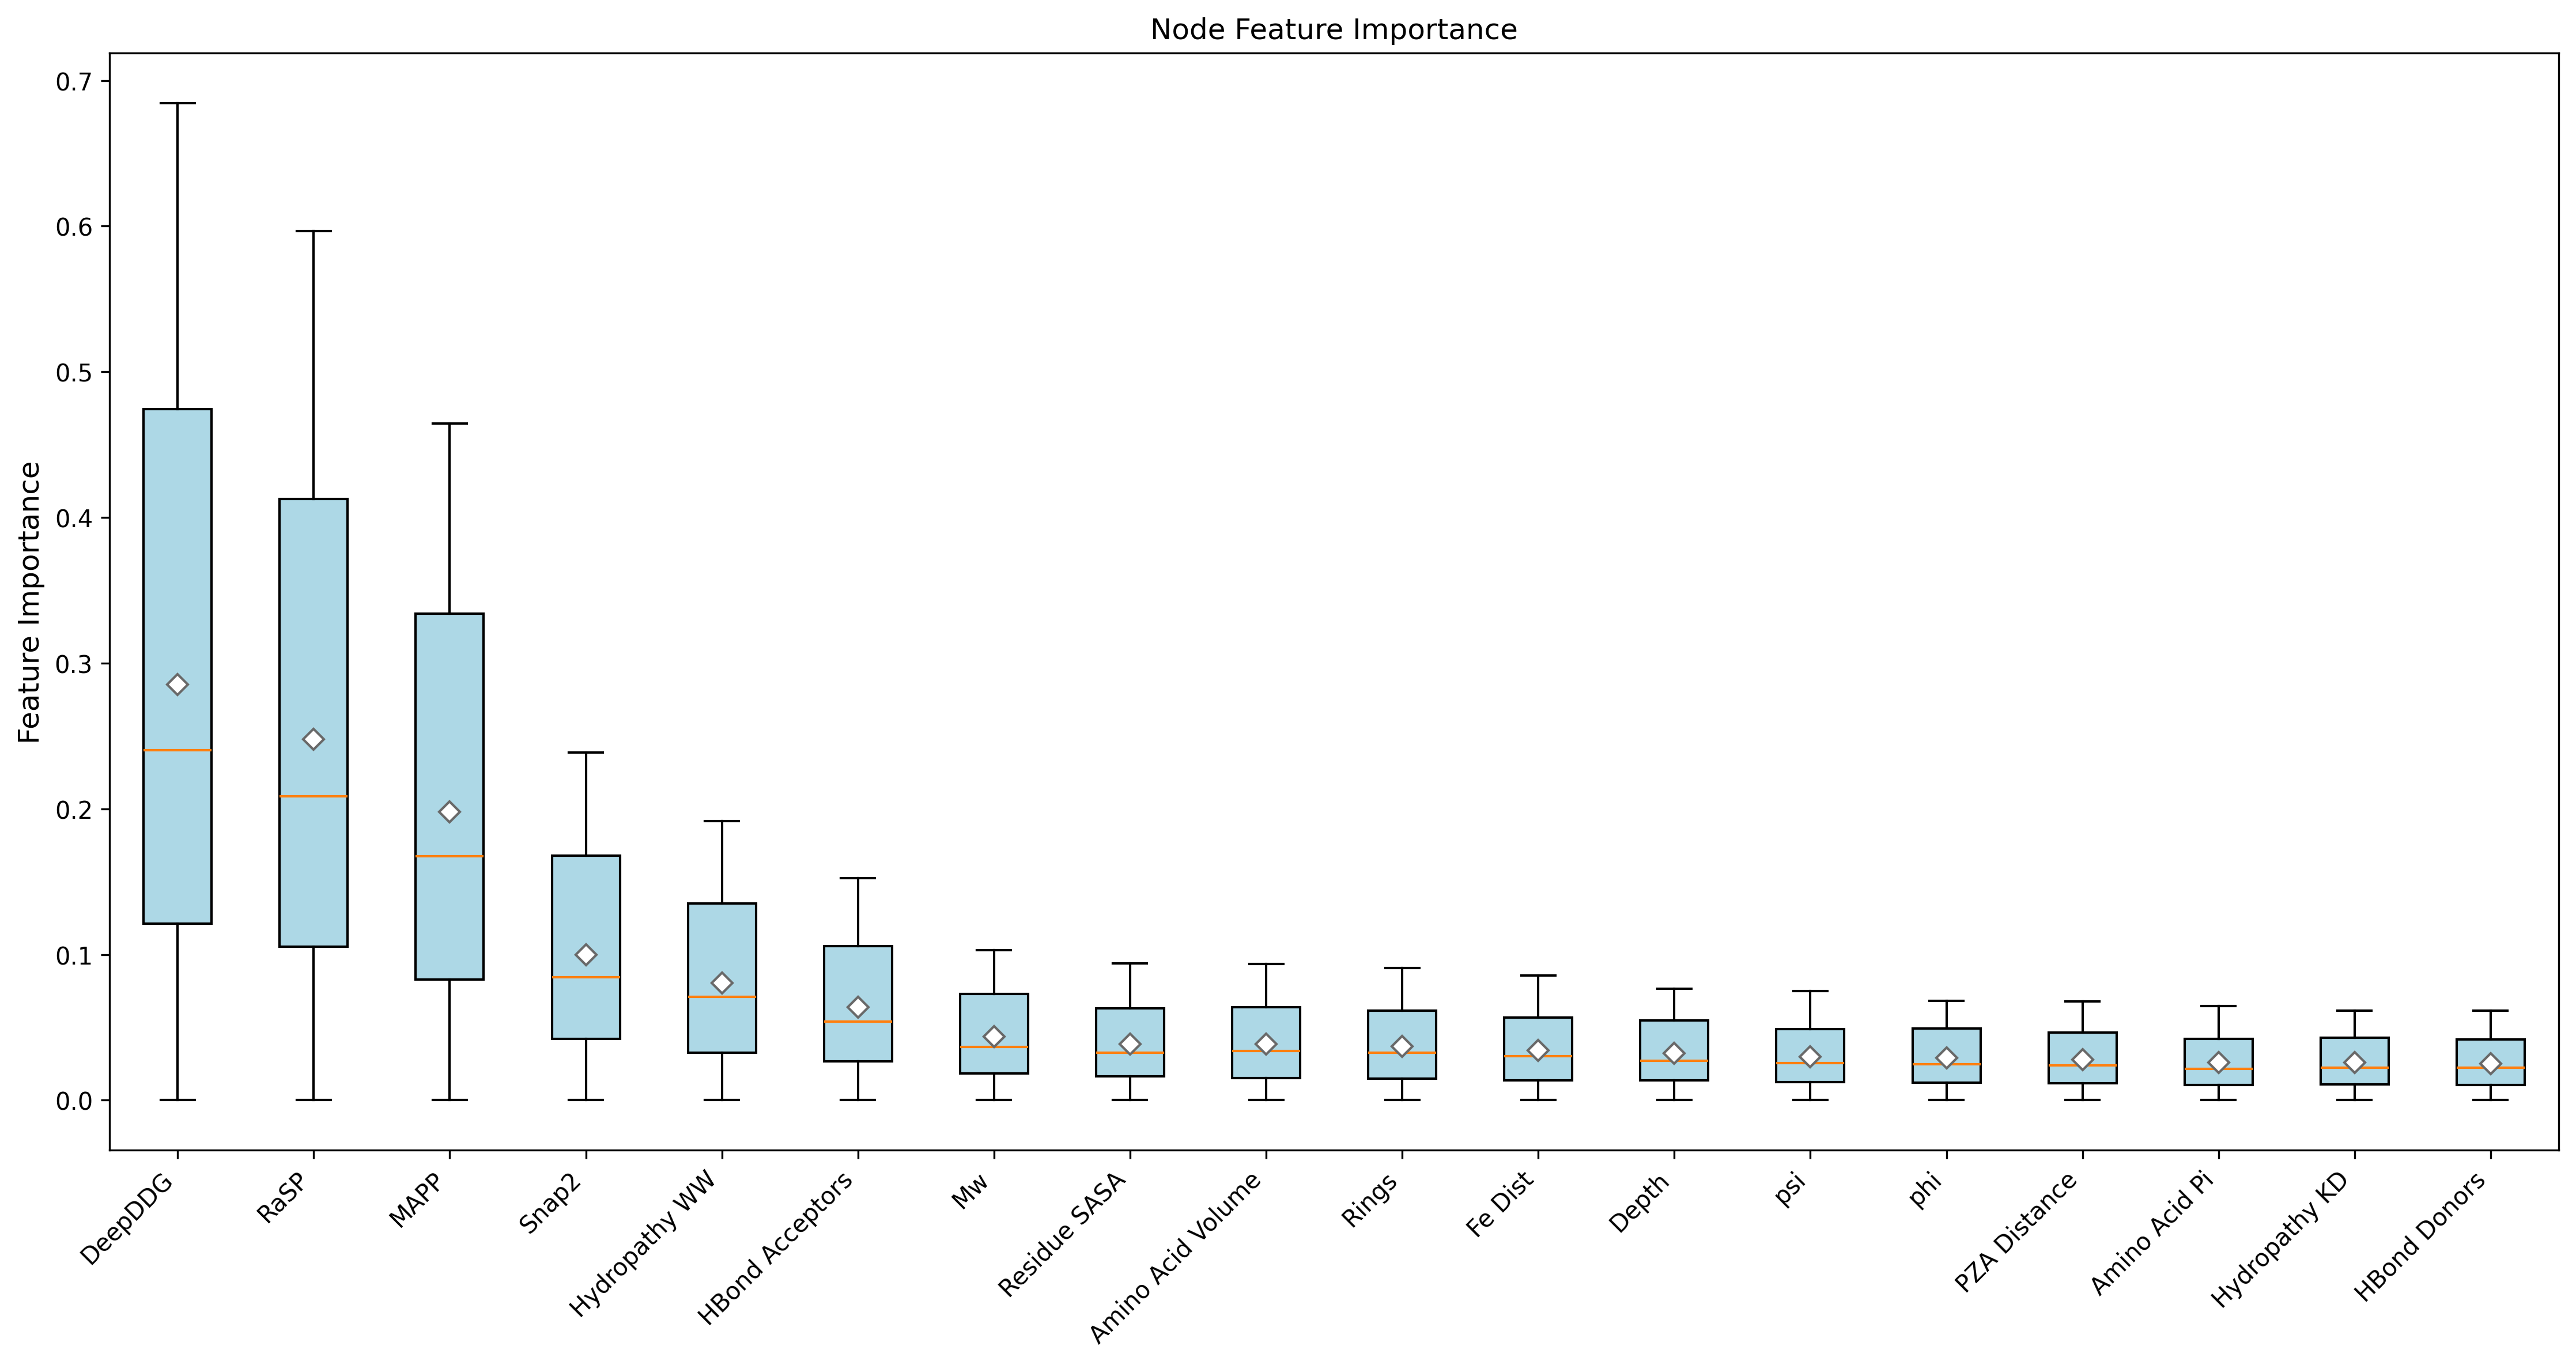

In [98]:
feature_labels = [
    'Amino Acid Volume', 'Hydropathy WW', 'Mw', 'Amino Acid Pi', 'Hydropathy KD',
    'HBond Acceptors', 'HBond Donors', 'Rings', 'PZA Distance', 'phi', 'psi',
    'Residue SASA', 'Depth', 'Fe Dist', 'Snap2', 'DeepDDG', 'RaSP', 'MAPP'
]

# Calculate mean importance for each feature
mean_importance = feat_imps.mean(dim=0).numpy()

# Sort features by mean importance (descending)
sorted_indices = np.argsort(mean_importance)[::-1]  # Descending order
sorted_means = mean_importance[sorted_indices]
sorted_labels = [feature_labels[i] for i in sorted_indices]

# Prepare data for boxplot (sorted)
feature_data = [feat_imps[:, i].numpy() for i in sorted_indices]

# Create boxplot
plt.figure(figsize=(15, 8))
box_plot = plt.boxplot(
    feature_data, 
    labels=sorted_labels, 
    patch_artist=True, 
    showfliers=False, 
    showmeans=True,
    meanprops={'marker':'D', 'markerfacecolor':'white',
                       'markeredgecolor':'dimgray', 'linestyle':'--'},)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.ylabel('Feature Importance')
plt.title('Node Feature Importance')
# plt.grid(True, alpha=0.3)
# plt.ylim(-0.5, 5)
# Color the boxes
colors = ['lightblue'] * 18
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()